<a href="https://colab.research.google.com/github/MarcoParola/medical_images_classification/blob/main/Pretrained_CNN_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import optimizers

In [ ]:
projectPath = 'drive/MyDrive/Colab Notebooks/cidl/'
dataPath = 'numpy data/'

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/.shortcut-targets-by-id/1H_qsSPBi-K_nGcMzSsNcwFkqtAHG8iYD/cidl
/content


In [ ]:
# load data
imagesTrainPub, labelsTrainPub, imagesTestPub, labelsTestPub, imagesTestPriv = load_data(projectPath + dataPath)

# normalize data 
imagesTrainPub = scaleData(imagesTrainPub)
imagesTestPub = scaleData(imagesTestPub)

In [ ]:
# create (if not exists) the folder to store the models
dir_name = 'models'
if not os.path.exists(projectPath + dir_name):
  os.makedirs(projectPath + dir_name)

# **Task 3**

## 3.1 Binary calssification: Mass and Calcification
Classes:
*   Mass 1218
*   Calcification 1458

In [ ]:
# 0 -> mass
# 1 -> calcification

# prepare trainig-set
trainingSet = []
trainingLabels = []

for i in range(len(labelsTrainPub)):
  if labelsTrainPub[i] == 1 or labelsTrainPub[i] == 2:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(0)
  if labelsTrainPub[i] == 3 or labelsTrainPub[i] == 4:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(1)

trainingSet = np.array(trainingSet)
trainingSet = trainingSet.reshape(2676, 150, 150, 1)

training = []
for i in range(len(trainingSet)):
  training.append((trainingSet[i], trainingLabels[i]))

training = np.array(training)
np.random.shuffle(training)


trainingSet = []
trainingLabels = []

for i in range(len(training)):
  trainingSet.append(training[i][0])
  trainingLabels.append(training[i][1])

trainingSet = np.array(trainingSet)
trainingLabels = np.array(trainingLabels)

# prepare test-set
testSet = []
testLabels = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 2:
    testSet.append(imagesTestPub[i])
    testLabels.append(0)
  if labelsTestPub[i] == 3 or labelsTestPub[i] == 4:
    testSet.append(imagesTestPub[i])
    testLabels.append(1)

testSet = np.array(testSet)
testSet = testSet.reshape(336, 150, 150, 1)

# the output must have a categorigal values
testLabelsCategorical = to_categorical(np.array(testLabels))
trainingLabelsCategorical = to_categorical(np.array(trainingLabels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **Augment Data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
dataGenerator = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=20,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='reflect')


augmentedData = []
augmentedLabels = []

for j in range(0,len(trainingSet)):
  for i in range(0,4):
    dataGenerated = dataGenerator.flow(trainingSet[j].reshape(1,150,150,1), batch_size=4)
    augmentedData.append(dataGenerated[0].reshape(150, 150))
    augmentedLabels.append(trainingLabels[j])
    del dataGenerated

augmentedLabels = to_categorical((np.array(augmentedLabels)))

augmentedData = np.array(augmentedData)
augmentedData = augmentedData.reshape(len(augmentedData), 150, 150, 1)
print(augmentedData.shape, augmentedLabels.shape)

(10704, 150, 150, 1) (10704, 2)


# **VGG16**
We test VGG16 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

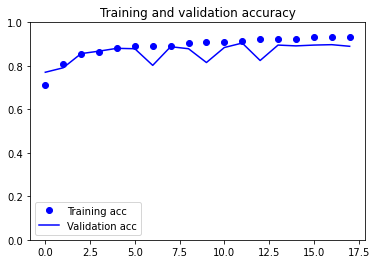

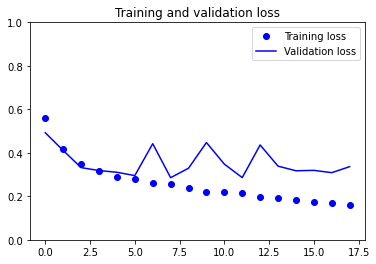

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


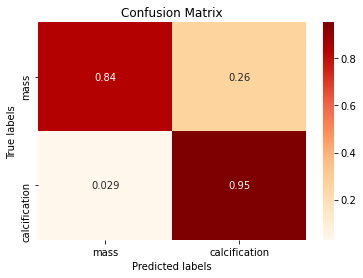

In [ ]:
from tensorflow.keras.applications import VGG16

#import pretrained model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()


# add fully connected layers as classifier
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# Freeze layers
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# trick to use the pretrained network on gray scale immages
trainingSet = np.repeat(trainingSet,3, axis = 3)
testSet = np.repeat(testSet,3, axis = 3)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(trainingSet, trainingLabelsCategorical, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)


test_loss, test_acc = model.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model, testSet, testLabels)

# **ResNet50**

We test ResNet50 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/100
67/67 [==============================] - 9s 90ms/step - loss: 0.7128 - accuracy: 0.5235 - val_loss: 0.7086 - val_accuracy: 0.4422
Epoch 2/100
67/67 [==============================] - 5s 69ms/step - loss: 0.7062 - accuracy: 0.5067 - val_loss: 0.7228 - val_accuracy: 0.4422
Epoch 3/100
67/67 [==============================] - 5s 68ms/step - loss: 0.6976 - accuracy: 0.5069 - val_loss: 0.6856 - val_accuracy: 0.5578
Epoch 4/100
67/67 [==============================] - 5s 69ms/step - loss: 0.6872 - accuracy: 0.5626 - val_loss: 0.7148 - val_accuracy: 0.4422
Epoch 5/100
67/67 [==============================] - 5s 69ms/step - loss: 0.6980 - accuracy: 0.5323 - val_loss: 0.6821 - val_accuracy: 0.5578
Epoch 6/100
67/67 [==============================] - 5s 69ms/step - loss: 0.6919 - accuracy: 0.5455 - val_loss: 0.7018 - val_accuracy: 0.5578
Epoch 7/100
67/67 [==============================] - 5s 69ms/step - loss: 0.6920 - 

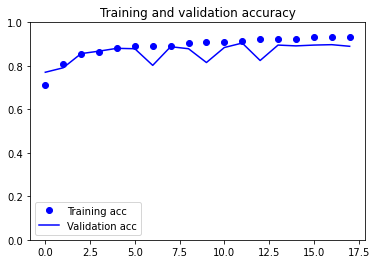

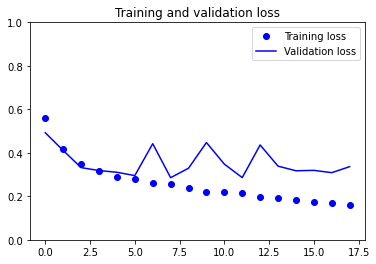

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


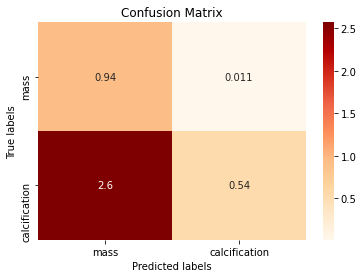

In [ ]:
from tensorflow.keras.applications import ResNet50

# trick to riproduce 3 layer
img_input = tf.keras.layers.Input(shape=(150, 150, 1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

# pre-trained network
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# classifier
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

        model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.fit(trainingSet, trainingLabelsCategorical, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model, testSet, testLabels)